<a href="https://colab.research.google.com/github/bwsi-hadr/2019-student-final-exercise/blob/master/Planning_Hospital_Lee_Joseph_Final_exercise_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [0]:
# need to specify location of some certificates for rasterio
!export CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt
!sudo mkdir -p /etc/pki/tls/certs
!sudo cp /etc/ssl/certs/ca-certificates.crt /etc/pki/tls/certs/ca-bundle.crt
try:
  import rasterio
  import rasterio.plot
  import rasterio.merge 
  import rasterio.mask
except:
  !pip install rasterio
  import rasterio
  import rasterio.plot
  import rasterio.merge
  import rasterio.mask
  
try:
  import rasterstats as rs
except:
  !pip install rasterstats  
  import rasterstats as rs
  
try:
  import pyproj
except:
  !pip install pyproj
  import pyproj
  
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/BWSI-Remote-Sensing/'Final_exercise'

In [0]:
import os

#Base Grid

In [0]:
base_grid = gpd.read_file('game_grid_export/game_grid_all_stats.shp')

In [111]:
base_grid.head()
# -71.79092278136125 42.58943590354409

,MGRS,kmSQ_ID,GZD,EASTING,NORTHING,MGRS_10km,Shape_Leng,Shape_Le_1,Shape_Area,x_centroid,y_centroid,elevation,population,Health,Utility,Transporta,geometry
0,19TBH7019,BH,19T,270000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.797211,42.593785,196.344985,443,10,7,8,POLYGON ((-71.79092278136125 42.58943590354409...
1,19TBH7119,BH,19T,271000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.785036,42.594082,139.760744,381,10,7,8,POLYGON ((-71.77874932612048 42.58973201162303...
2,19TBH7219,BH,19T,272000mE,4719000mN,19TBH71,0.042364,0.042364,0.00011,-71.772862,42.594377,144.429830,318,10,7,8,POLYGON ((-71.76657568741803 42.59002682737616...
3,19TBH7319,BH,19T,273000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.760687,42.594671,154.567869,182,10,7,3,POLYGON ((-71.75440186615322 42.59032035170287...
4,19TBH7419,BH,19T,274000mE,4719000mN,19TBH71,0.042365,0.042365,0.00011,-71.748513,42.594964,176.765537,115,10,7,3,POLYGON ((-71.74222786322531 42.59061258370377...


#Directory Determiner

In [112]:
os.listdir('game2')

['prep_turn_0',
 'prep_turn_1',
 'prep_turn_2',
 'response_turn_0',
 'response_turn_1',
 'response_turn_2',
 'response_turn_3',
 'prep_turn_3']

In [113]:
file_path = 'game2/prep_turn_{}/{}.shp' if 'prep_turn' in \
os.listdir('game2') else'game2/response_turn_{}/{}.shp'
print(file_path)
game_grid = gpd.read_file(file_path.format(2, 'curr_grid'))
# What do transporta(tion) values mean again?

game2/response_turn_{}/{}.shp


#Safecasing prev_grid

In [0]:
try:
  if prev_grid.empty:
    prev_grid = None
except:
  prev_grid = None

In [115]:
type(prev_grid)

geopandas.geodataframe.GeoDataFrame

#From Base Grid -> Game Grid

In [0]:

game_grid['MGRS'] = base_grid['MGRS']
try:
  game_grid['population'] = prev_grid['population']
except:  
  game_grid['population'] = base_grid['population']

game_grid['elevation'] = base_grid['elevation'] 
game_grid['Utility'] = base_grid['Utility']
game_grid.set_index('MGRS', inplace = True)


In [118]:
game_grid.head()

,Health,Utility,Transporta,geometry,population,elevation
MGRS,,,,,,
19TBH7019,5,7,5,POLYGON ((-71.79092278136125 42.58943590354409...,443,196.344985
19TBH7119,1,7,4,POLYGON ((-71.77874932612048 42.58973201162303...,381,139.760744
19TBH7219,1,7,1,POLYGON ((-71.76657568741803 42.59002682737616...,318,144.429830
19TBH7319,5,7,1,POLYGON ((-71.75440186615322 42.59032035170287...,182,154.567869
19TBH7419,4,7,1,POLYGON ((-71.74222786322531 42.59061258370377...,115,176.765537


#Normalization (Population & Elevation)

In [119]:
maxi_pop = game_grid['population'].max() # CAN change
maxi_ele = base_grid['elevation'].max() # can NOT change
print(maxi_ele)

# game_grid = game_grid.loc[game_grid['population'] != 0]
game_grid['normalized_pop'] = game_grid['population'] / maxi_pop * 10
game_grid['normalized_ele'] = game_grid['elevation'] / maxi_ele * 10

game_grid.head()

259.2527327221439


,Health,Utility,Transporta,geometry,population,elevation,normalized_pop,normalized_ele
MGRS,,,,,,,,
19TBH7019,5,7,5,POLYGON ((-71.79092278136125 42.58943590354409...,443,196.344985,0.419388,7.573497
19TBH7119,1,7,4,POLYGON ((-71.77874932612048 42.58973201162303...,381,139.760744,0.360693,5.390907
19TBH7219,1,7,1,POLYGON ((-71.76657568741803 42.59002682737616...,318,144.429830,0.301051,5.571005
19TBH7319,5,7,1,POLYGON ((-71.75440186615322 42.59032035170287...,182,154.567869,0.172300,5.962054
19TBH7419,4,7,1,POLYGON ((-71.74222786322531 42.59061258370377...,115,176.765537,0.108871,6.818271


#Evacuation Grid

In [120]:
try:
  evac_grid = gpd.read_file('game2/prep_turn_0/evacuation.shp')
  evac_grid.set_index('MGRS', inplace = True)
  print(evac_grid.head().to_string())
except:
  evac_grid = None
  

          kmSQ_ID  GZD   EASTING   NORTHING MGRS_10km  Shape_Leng  Shape_Le_1  Shape_Area  x_centroid  y_centroid  elevation  population  Health  Utility  Transporta     score  index_righ     STATE_NAME                                           geometry
MGRS                                                                                                                                                                                                                                                         
19TDF1599      DF  19T  415000mE  4599000mN   19TDF19    0.041990    0.041990    0.000108  -70.013087   41.542698   0.200436           0      10        5           3  1.689431           4  Massachusetts  POLYGON ((-70.00702313710809 41.53824772675114...
19TCF2994      CF  19T  329000mE  4594000mN   19TCF29    0.041958    0.041958    0.000108  -71.042270   41.483989   0.200880           3      10        7           3  1.419392           3  Massachusetts  POLYGON ((-71.03614388353338 41.47

In [0]:
game_grid.loc['19TDF1599']

In [0]:
pop_col = game_grid.loc[evac_grid.index, 'population']
pop_col *= 0.85
pop_col = round(pop_col)
game_grid.loc[evac_grid.index, 'population'] = pop_col

In [123]:
game_grid.head()

,Health,Utility,Transporta,geometry,population,elevation,normalized_pop,normalized_ele
MGRS,,,,,,,,
19TBH7019,5,7,5,POLYGON ((-71.79092278136125 42.58943590354409...,443.0,196.344985,0.419388,7.573497
19TBH7119,1,7,4,POLYGON ((-71.77874932612048 42.58973201162303...,381.0,139.760744,0.360693,5.390907
19TBH7219,1,7,1,POLYGON ((-71.76657568741803 42.59002682737616...,318.0,144.429830,0.301051,5.571005
19TBH7319,5,7,1,POLYGON ((-71.75440186615322 42.59032035170287...,182.0,154.567869,0.172300,5.962054
19TBH7419,4,7,1,POLYGON ((-71.74222786322531 42.59061258370377...,115.0,176.765537,0.108871,6.818271


In [0]:
game_grid['Vulnerability'] = 0.5 * game_grid['Health'] + 0.1 * game_grid['normalized_ele'] +  \
0.10 * (10 - game_grid['Transporta']) + 0.10 * game_grid['Utility'] + 0.2 * (10 - game_grid['normalized_pop'])

In [125]:
game_grid.head()

,Health,Utility,Transporta,geometry,population,elevation,normalized_pop,normalized_ele,Vulnerability
MGRS,,,,,,,,,
19TBH7019,5,7,5,POLYGON ((-71.79092278136125 42.58943590354409...,443.0,196.344985,0.419388,7.573497,6.373472
19TBH7119,1,7,4,POLYGON ((-71.77874932612048 42.58973201162303...,381.0,139.760744,0.360693,5.390907,4.266952
19TBH7219,1,7,1,POLYGON ((-71.76657568741803 42.59002682737616...,318.0,144.429830,0.301051,5.571005,4.596890
19TBH7319,5,7,1,POLYGON ((-71.75440186615322 42.59032035170287...,182.0,154.567869,0.172300,5.962054,6.661745
19TBH7419,4,7,1,POLYGON ((-71.74222786322531 42.59061258370377...,115.0,176.765537,0.108871,6.818271,6.260053


In [126]:
game_grid.sort_values(by = 'Vulnerability', inplace = True)
game_grid.head()

,Health,Utility,Transporta,geometry,population,elevation,normalized_pop,normalized_ele,Vulnerability
MGRS,,,,,,,,,
19TCF5391,1,5,5,POLYGON ((-70.74810150028401 41.45731318075866...,0.0,0.421219,0.000000,0.016247,3.501625
19TCH0417,1,7,8,"POLYGON ((-71.376243194268 42.5807826241188, -...",358.0,60.529538,0.338919,2.334770,3.565693
19TCH0116,1,7,9,POLYGON ((-71.41242244264163 42.57102110294153...,156.0,81.680423,0.147685,3.150610,3.585524
19TBH9718,1,7,8,POLYGON ((-71.46182313792747 42.58797984629285...,257.0,66.730963,0.243302,2.573973,3.608737
19TCF7378,1,5,3,POLYGON ((-70.50601594937655 41.34364435999919...,0.0,0.512572,0.000000,0.019771,3.701977


In [0]:
# for i in game_grid.index:
#   print(i)

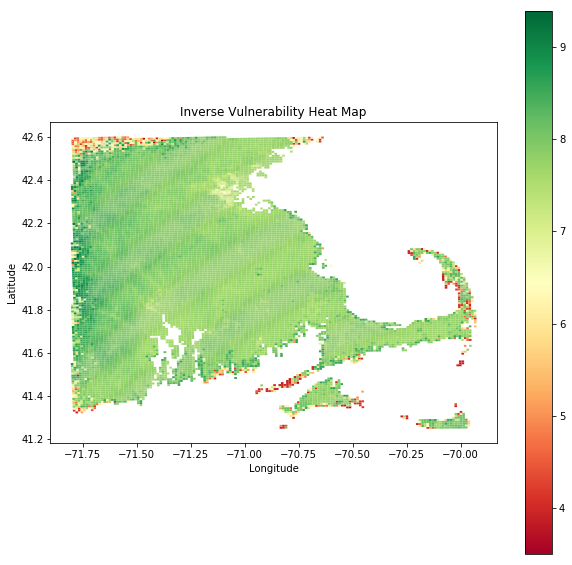

In [131]:
fig=plt.figure(figsize=[10,10])
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Inverse Vulnerability Heat Map')
game_grid.plot(ax = ax, column = 'Vulnerability', legend = True, cmap = 'RdYlGn')

#Setting up prev_grid

In [52]:
prev_grid = game_grid.copy()
prev_grid.head()

,Health,Utility,Transporta,geometry
0,5,10,5,POLYGON ((-71.79092278136125 42.58943590354409...
1,1,10,4,POLYGON ((-71.77874932612048 42.58973201162303...
2,1,10,1,POLYGON ((-71.76657568741803 42.59002682737616...
3,5,10,1,POLYGON ((-71.75440186615322 42.59032035170287...
4,4,10,1,POLYGON ((-71.74222786322531 42.59061258370377...


#End of Vulnerability Analysis

In [0]:
if prev_grid.empty:
  print('no!!!')

#Hospitals

In [0]:
hospital_grid = gpd.read_file('game_grid_export/facilities/hospitals.shp')
hospital_grid['hos_radius (km)'] = 0
hospital_grid.loc[hospital_grid.loc[:, 'BEDS'] >= 200, 'hos_radius (km)'] = 25
hospital_grid.loc[hospital_grid.loc[:, 'BEDS'] < 200, 'hos_radius (km)'] = 15

In [0]:
hospital_grid

In [0]:
game_grid['centroid'] = game_grid['geometry'].centroid

In [0]:
grid = game_grid.to_crs(epsg=3857)

In [0]:
to_m = lambda km: km * 1000

In [0]:
grid = game_grid.to_crs(epsg = 3857)
big_hospitals=hospital_grid[hospital_grid['BEDS']>=200].to_crs(grid.crs)
small_hospitals=hospital_grid[hospital_grid['BEDS']<200].to_crs(grid.crs)
hospitals_buffered = hospital_grid.copy().to_crs(grid.crs)
hospitals_buffered.loc[big_hospitals.index, 'geometry'] = hospitals_buffered.loc[big_hospitals.index,'geometry'].buffer(to_m(25))
hospitals_buffered.loc[small_hospitals.index, 'geometry'] = hospitals_buffered.loc[small_hospitals.index,'geometry'].buffer(to_m(15))

In [0]:
fig=plt.figure(figsize=[20,20])
ax=fig.add_subplot(1,1,1)
grid.plot(ax=ax, column='Utility', legend=True)
big_hospitals.buffer(to_m(25)).plot(color='red', ax=ax, zorder=15)
small_hospitals.buffer(to_m(15)).plot(color='orange', ax=ax, zorder=15)

In [0]:
grid

In [0]:
hospitals_buffered

In [0]:
hosp_info = gpd.sjoin(grid, hospitals_buffered, how = 'inner', op = 'intersects')
hosp_info

In [0]:
hosp_infopop = hosp_info.groupby('NAME').sum()

In [0]:
alpha_hosp = hospitals_buffered.sort_values('NAME').set_index('NAME')
alpha_hosp['population'] = hosp_infopop['population'].values
alpha_hosp

In [0]:
alpha_hosp['population']

#Set Cover Application Algorithm

In [0]:
large_hos_cost = 200
small_hos_cost = 100

cost_ref = {'small': small_hos_cost, 'big': large_hos_cost}

In [0]:
hosp_to_cells = {}
for i, row in hosp_info.iterrows():
  hosp_name = row["NAME"]
  size = 'small' if row['BEDS'] < 200 else 'big'
  if hosp_name not in hosp_to_cells:
    hosp_to_cells[(hosp_name, size)] = {i}
  else:
    hosp_to_cells[(hosp_name, size)].add(i)

In [0]:
hosp_to_cells

In [0]:
hosp_to_cells
freq_chart = [0 for _ in range(game_grid.shape[0])]
covered = set()

def calc_weight(subset, size):
  return sum(grid.loc[cell, 'population'] for cell in subset) / cost_ref[size]

    
    
def set_cover(budget, hosp_squares):#TODO: add cost_ref
  to_ret = set()
  while budget > 0:
    max_hosp, max_subset = max(hosp_squares.items(), key = lambda tup: \
                               calc_weight(tup[1], tup[0][1]))
    for cell in max_subset:
      freq_chart[cell] += 1
      /if freq_chart[cell] == 2:
      /  covered.add(cell)
    
    budget -= cost_ref[max_hosp[1]]
    to_ret.add(max_hosp)
    
    for key in hosp_squares:
      hosp_squares[key] -= max_subset
    del hosp_squares[max_hosp]
      
  return to_ret

In [0]:
flood_range = 500
flooding2 = flooding.copy().to_crs(grid.crs)
flooding2['geometry'] = flooding2['geometry'].buffer(flood_range)

In [0]:
flood_poly = flooding2.unary_union
print(type(flood_poly))

In [0]:
'''
parameters: would be one, like the closest you could be to a flood, and the second
one would be how far, like how the farthest you can be from the flood. Basically,
Deteremine the hospitals that the operations want to use, basically.

Sort it by population, and he already made the population column which each hosptial can hit.
Priotirize where the hospitals can help. This is kind of extra, but if I can,
I will determine if it's possible to open the hospitals with utility score. 
You need a minimum utility score to actually open a hospital. 
'''
def operator_hospitals(min_d, max_d, flood_poly):
  # Loop through all hospitals, see if the hospital in loop is in range
  hosp_list = []
  for i in range(len(hospital_grid)):
    dist = flood.exterior.distance(hopsital_grid.loc[i, 'geometry'])
    if dist < maxdist and dist > mindist:
      hosp_list.append(hospital_grid.loc[i, 'NAME'])
  return hosp_list
  
  
  

In [0]:
from shapely.geometry import MultiPolygon
import shapely.ops as shap

In [0]:
def fl_create(fl, b, i = 0):
  flooding = fl.copy().to_crs(grid.crs)
  flooding['geometry'] = flooding['geometry'].buffer(b)
  if i == 0:
    flood = flooding['geometry'].unary_union
  else:
    l = [MultiPolygon([flooding.loc[i, 'geometry'], \
                      flooding.loc[i + 1, 'geometry']]).convex_hull \
         for i in range(len(flooding) - 1)]
    flood = shap.cascaded_union(MultiPolygon(l))
  return flood

In [0]:
fl_create(flooding, 500, 1)

# Evacuation

In [0]:
ls